In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from function.utilities import get_subset

# param

In [2]:
#####CHANGE HERE#####
algorithm = "VLXT" 
#####CHANGE HERE#####

In [3]:
plot_subset = ['>30','>40','>50'] #'>20', '>30', '>40', '>50', '>60' 
table_s1_path = Path('./output/table_s1')

# load data

In [4]:
pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")

od_human_df = pd.read_pickle(pondr_disorder_ident_path / "{}_od_human_df.pkl".format(algorithm))
od_rbp_df = get_subset(od_human_df, "rbp")
od_mrbp_df = get_subset(od_human_df, "mrbp")

## diff list of rbp
numbers of rbps(1533) is a bit less than "Gerstberger, et al."(1542), mainly cause by duplicate records,
more informations are shown below


|no.|  gene name form  <br>Gerstberger, et al  | reason  |
|----|  :----  | :----  |
|1| PABPC1L2B | duplicate with **PABPC1L2A** |
|2| AARSD1    | duplicate with **PTGES3L-AARSD1** |
|3| FRG1B     | does not have uniprot_id |
|4| SMN2      | duplicate with **SMN1** |
|5| RPS17L    | duplicate with **RPS17**|
|6| RBMY1F    | duplicate with **RBMY1J**|
|7| RPL41     | sequence is too short |
|8| hCG_2045905| unreviewed from uniprot |
|9| VARS2| unreviewed from uniprot |

# consecutive disordered stat

In [5]:
# 微小差距是因為我用>= 老施用 >

In [6]:
def length_filter(disorder_length, od_ident):

    count = 0
    for i in od_ident:
        if i == "1":
            count = count + 1
            if count >= disorder_length:
                return 1
        else:
            count = 0
    return 0


def make_consecutive_disorder_stat(df):

    df[">20"] = df["od_ident"].apply(lambda x: length_filter(20, x))
    df[">30"] = df["od_ident"].apply(lambda x: length_filter(30, x))
    df[">40"] = df["od_ident"].apply(lambda x: length_filter(40, x))
    df[">50"] = df["od_ident"].apply(lambda x: length_filter(50, x))
    df[">60"] = df["od_ident"].apply(lambda x: length_filter(60, x))

    b20 = df[">20"].value_counts()[1] / len(df)
    b30 = df[">30"].value_counts()[1] / len(df)
    b40 = df[">40"].value_counts()[1] / len(df)
    b50 = df[">50"].value_counts()[1] / len(df)
    b60 = df[">60"].value_counts()[1] / len(df)

    b20 = round(b20 * 100, 1)
    b30 = round(b30 * 100, 1)
    b40 = round(b40 * 100, 1)
    b50 = round(b50 * 100, 1)
    b60 = round(b60 * 100, 1)

    return {">20": b20,
            ">30": b30, 
            ">40": b40, 
            ">50": b50,
            ">60": b60,}

In [7]:
mrbp = make_consecutive_disorder_stat(od_mrbp_df)
rbp = make_consecutive_disorder_stat(od_rbp_df)
human = make_consecutive_disorder_stat(od_human_df)
output = {"algorithm": algorithm, "human": human, "rbp": rbp, "mrbp": mrbp}
output

{'algorithm': 'VLXT',
 'human': {'>20': 81.8, '>30': 65.6, '>40': 52.0, '>50': 41.7, '>60': 33.7},
 'rbp': {'>20': 92.6, '>30': 79.5, '>40': 66.2, '>50': 54.7, '>60': 45.9},
 'mrbp': {'>20': 93.6, '>30': 84.4, '>40': 73.0, '>50': 62.6, '>60': 55.5}}

# plot

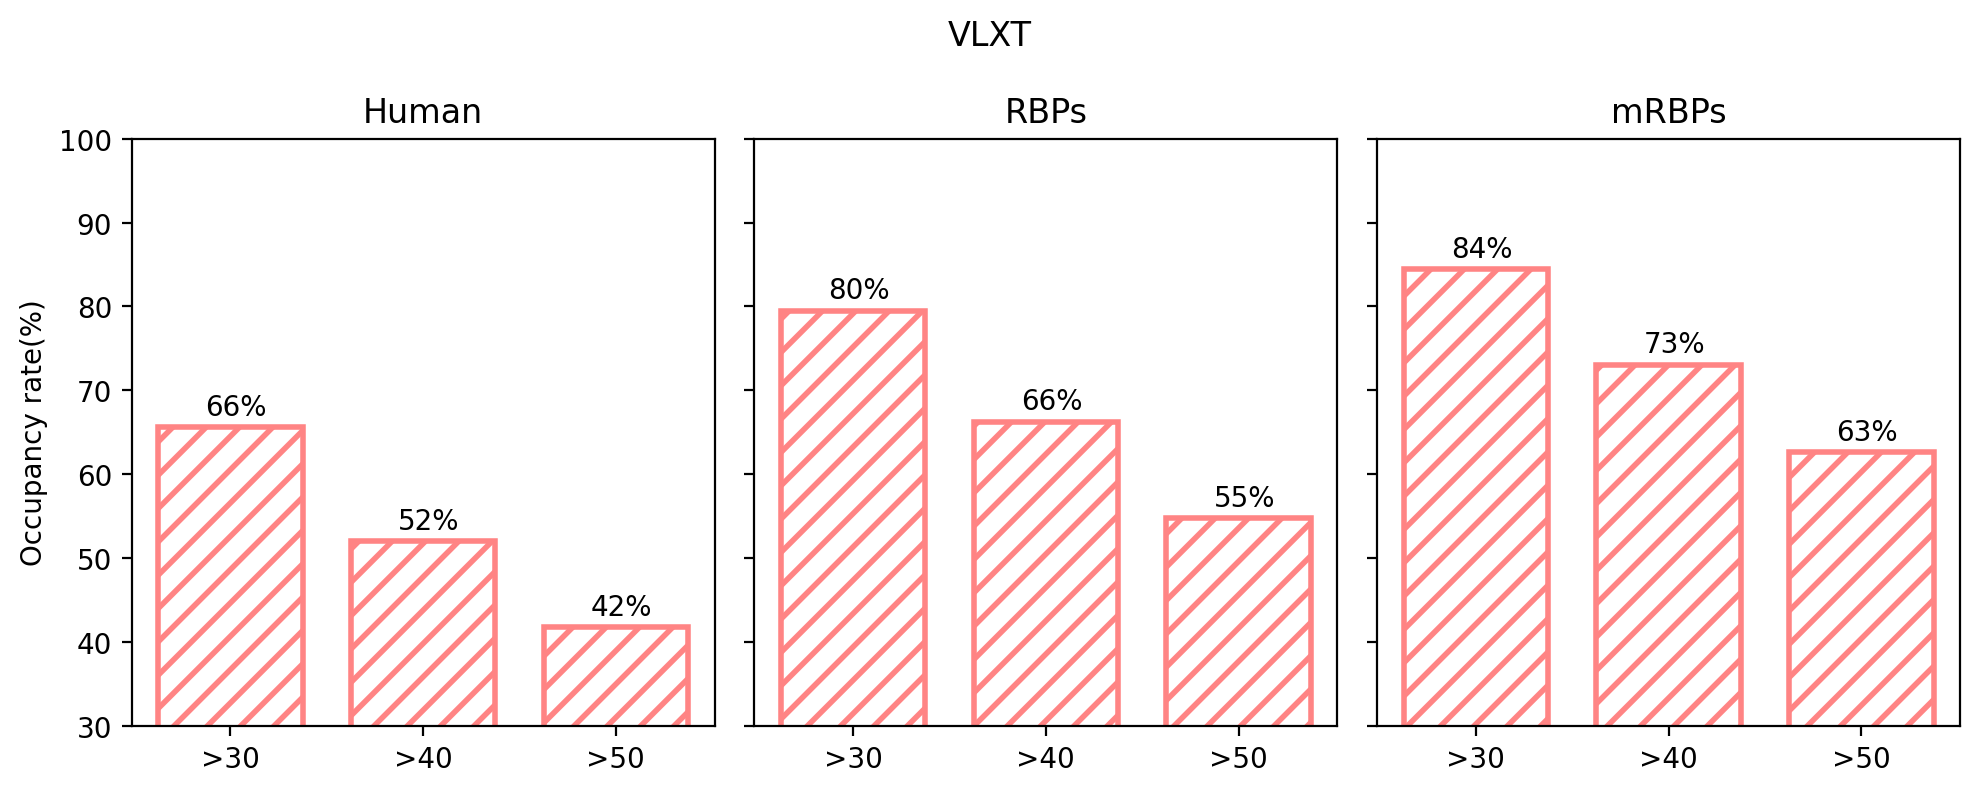

In [8]:
mpl.rcParams["hatch.linewidth"] = 2
f, (a0, a1, a2) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4), dpi=200)

X = np.arange(0, len(plot_subset))
human_plot_subset = [output["human"][x] for x in plot_subset]
rbp_plot_subset = [output["rbp"][x] for x in plot_subset]
mrbp_plot_subset = [output["mrbp"][x] for x in plot_subset]

a0.bar(X, human_plot_subset, width=0.75, tick_label=plot_subset, color="white", hatch="//", linewidth=2, edgecolor="#ff8484")
for x, y in zip(X,human_plot_subset):
    a0.text(x-0.13, y+1.5, "{}%".format(str(round(y))),fontsize=10)
a0.set_title("Human")
a0.set_ylabel("Occupancy rate(%)")
a0.set_ylim(30, 100)

a1.bar(X, rbp_plot_subset, width=0.75, tick_label=plot_subset, color="white", hatch="//", linewidth=2, edgecolor="#ff8484")
for x, y in zip(X,rbp_plot_subset):
    a1.text(x-0.13, y+1.5, "{}%".format(str(round(y))),fontsize=10)
a1.set_title("RBPs")

a2.bar(X, mrbp_plot_subset, width=0.75, tick_label=plot_subset, color="white", hatch="//", linewidth=2, edgecolor="#ff8484")
for x, y in zip(X,mrbp_plot_subset):
    a2.text(x-0.13, y+1.5, "{}%".format(str(round(y))),fontsize=10)
a2.set_title("mRBPs")


f.suptitle(algorithm)
f.tight_layout()

# table s1 output

In [9]:
df = pd.DataFrame()

df["Length longer than"] = output["human"].keys()
df["Human proteins (%)"] = output["human"].values()
df["RNA binding proteins (%)"] = output["rbp"].values()
df["(RBP Human) (%)"] = df["RNA binding proteins (%)"] - df['Human proteins (%)']
df["mRNA binding proteins (%)"] = output["mrbp"].values()
df["(mRBP Human) (%)"] = df["mRNA binding proteins (%)"] - df["Human proteins (%)"]

df.to_excel(table_s1_path/"{}.xlsx".format(algorithm))
df

,Length longer than,Human proteins (%),RNA binding proteins (%),(RBP Human) (%),mRNA binding proteins (%),(mRBP Human) (%)
0,>20,81.8,92.6,10.8,93.6,11.8
1,>30,65.6,79.5,13.9,84.4,18.8
2,>40,52.0,66.2,14.2,73.0,21.0
3,>50,41.7,54.7,13.0,62.6,20.9
4,>60,33.7,45.9,12.2,55.5,21.8
